First Shallow water model solver:

The equations are as follows:

$$
\frac{\partial h}{\partial t} + \frac{\partial (hu)}{\partial x} = 0
$$

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = -g\frac{\partial h}{\partial x}
$$

or Alterntivly, what we are solving here:

$$
\frac{\partial h}{\partial t} + \frac{\partial (hu)}{\partial x} = 0
$$

$$
\frac{\partial u}{\partial t} + \frac{\partial}{\partial x}u^2h + \frac{1}{2}g\frac{\partial h^2}{\partial x} = 0
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse.linalg import factorized
from PIL import Image

In [2]:
from pathlib import Path
# Create used directories
directories = ["gifs", "PINN_Plots", "plots"]
for d in directories:
    plots_dir = Path(d)
    plots_dir.mkdir(exist_ok=True)
    print(f"Directory '{plots_dir}' is present. ✅")

Directory 'gifs' is present. ✅
Directory 'PINN_Plots' is present. ✅
Directory 'plots' is present. ✅


In [3]:
# Define PDE Parameters
xi, xf, dx = 0, 1, 1e-2
t0, tf, dt = 0, 10, 1e-3

g = 5e-3
x = np.arange(xi, xf + dx, dx)
t = np.arange(t0, tf + dt, dt)
Nx, Nt = len(x), len(t)

def h0(x):
    return 2 - np.cos(2*np.pi*x)

def u0(x):
    return 0*x

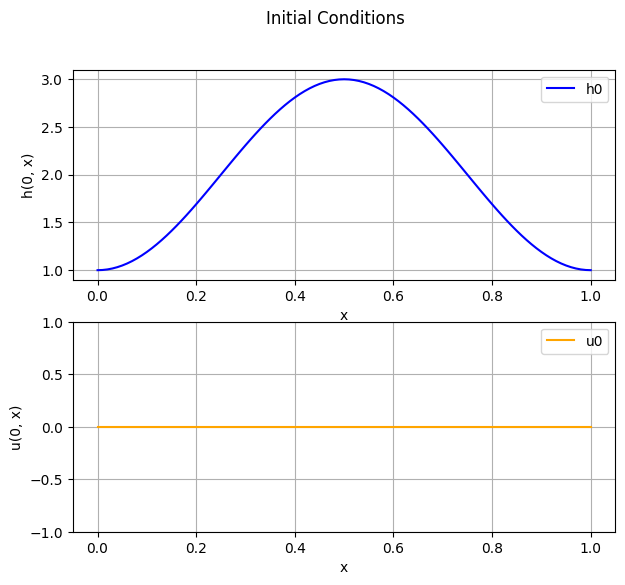

In [4]:
fig, axs = plt.subplots(figsize=(7, 6), nrows=2)
axs[0].plot(x, h0(x), label="h0", c="blue")
axs[0].set_xlabel('x')
axs[0].set_ylabel('h(0, x)')
axs[0].grid()
axs[0].legend()

axs[1].plot(x, u0(x), label="u0", c="orange")
axs[1].set_xlabel('x')
axs[1].set_ylabel('u(0, x)')
axs[1].grid()
axs[1].set_ylim(-1, 1)
axs[1].legend()

fig.suptitle("Initial Conditions")
plt.show()

In [5]:
def D_t():
    d = 1/(12*dx)
    D = d * diags([1, -8, 0, 8, -1], [-2, -1, 0, 1, 2], shape=(Nx, Nx)).toarray()
    D[0, [-2, -1]] = [d, -8*d]
    D[1, [-1]] = [d]
    D[-1, [0, 1]] = [8*d, -d]
    D[-2, [0]] = [-d]
    return sparse.csr_matrix(D)


h = np.zeros((Nt, Nx))
u = np.zeros((Nt, Nx))

D1 = D_t()

def solver(X, hk, uk):
    N = int(len(X)/2)
    hj, uj = X[:N], X[N:] # Future Values
    eq1 = hj - hk + dt*0.5*(D1@(hj*uj) + D1@(hk*uk))
    eq2 = hj*uj - hk*uk + dt*0.5*(D1@(hj*uj**2) + D1@(hk*uk**2)) + dt*0.25*g*(D1@(hj**2) + D1@(hk**2))
    return np.concatenate([eq1, eq2])

In [6]:
for j, tj in enumerate(t):
    if j == 0:
        h[0, :] = h0(x)
        u[0, :] = u0(x)
    else:
        try:
            k = j-1
            hk, uk = h[k, :], u[k, :]
            res = fsolve(solver, np.concatenate([hk, uk]), args=(hk, uk))
            h[j, :] = res[:Nx]
            u[j, :] = res[Nx:]
        except Exception as e:
            print(f"fsolve failed at time step {j}: {e}")
            break
        
    if j % int(1/dt * 1e-1) == 0:
        print(f"Time {tj:.3f}s, max h = {np.max(np.abs(h[j, :])):.3f}, max u = {np.max(np.abs(u[j, :])):.3f}")

Time 0.000s, max h = 3.000, max u = 0.000
Time 0.100s, max h = 2.997, max u = 0.003
Time 0.200s, max h = 2.988, max u = 0.006
Time 0.300s, max h = 2.974, max u = 0.009
Time 0.400s, max h = 2.954, max u = 0.012
Time 0.500s, max h = 2.929, max u = 0.015
Time 0.600s, max h = 2.900, max u = 0.018
Time 0.700s, max h = 2.867, max u = 0.021
Time 0.800s, max h = 2.830, max u = 0.024
Time 0.900s, max h = 2.790, max u = 0.027
Time 1.000s, max h = 2.748, max u = 0.029
Time 1.100s, max h = 2.704, max u = 0.032
Time 1.200s, max h = 2.659, max u = 0.034
Time 1.300s, max h = 2.612, max u = 0.037
Time 1.400s, max h = 2.565, max u = 0.039
Time 1.500s, max h = 2.518, max u = 0.041
Time 1.600s, max h = 2.471, max u = 0.043
Time 1.700s, max h = 2.424, max u = 0.044
Time 1.800s, max h = 2.377, max u = 0.046
Time 1.900s, max h = 2.331, max u = 0.047
Time 2.000s, max h = 2.286, max u = 0.049
Time 2.100s, max h = 2.241, max u = 0.050
Time 2.200s, max h = 2.197, max u = 0.050
Time 2.300s, max h = 2.155, max u 

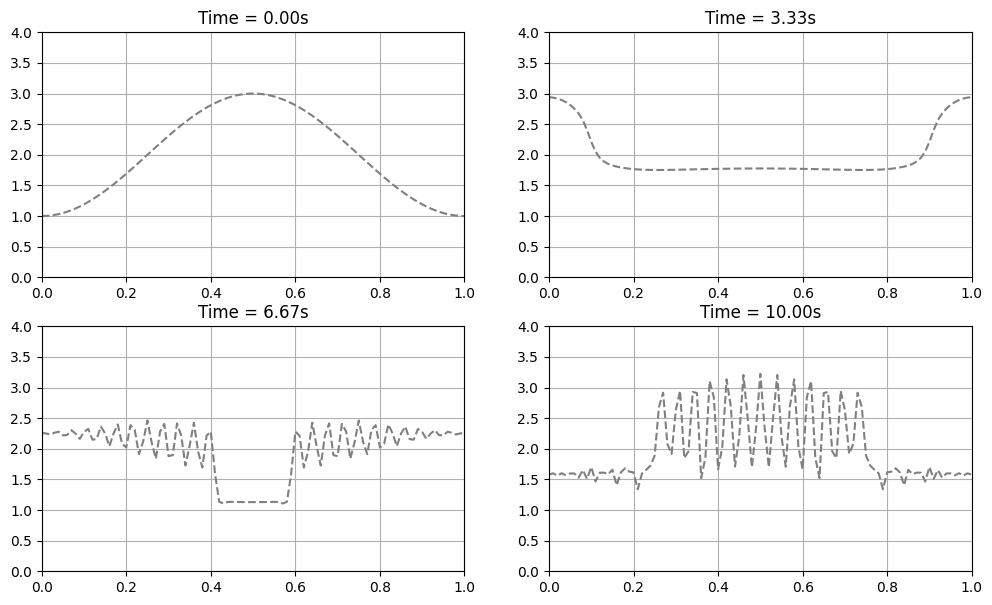

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
time_indecies = np.linspace(0, Nt-1, 4, dtype=int)
for j, ax in enumerate(axs.flat):
    tj = time_indecies[j]
    ax.plot(x, h[tj, :], c="gray", linestyle='--')
    ax.set_title(f"Time = {t[tj]:.2f}s")
    ax.grid()
    ax.set_ylim(0, 4)
    ax.set_xlim(xi, xf)

plt.show()

In [8]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=round(1000/fps), loop=loop)

def make_plot(save=False, file_name=f"PDE_solution.png", ti=0):
    "Helper function for plotting"
    fig, axs = plt.subplots(nrows=2)
    axs[0].plot(x, h[index, :], color="blue", lw=1.5)
    axs[0].set_xlim(xi, xf)
    axs[0].set_ylim(0, 4)
    axs[0].grid()
    
    axs[1].plot(x, u[index, :], color="orange", lw=1.5)
    axs[1].set_xlim(xi, xf)
    axs[1].set_ylim(-2, 2)
    fig.suptitle(f"Time = {ti:.3f}s")
    if save:
        fig.savefig(file_name, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")

In [9]:
import os
import shutil

folder_path="plots"
for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  # Remove file or symbolic link
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # Remove subdirectory and its contents
    except Exception as e:
        print(f"Failed to delete {item_path}. Reason: {e}")

In [10]:
files = []
fps   = 20
frame_indicies = np.linspace(0, Nt-1, int(fps*t[-1]), dtype=int)
N_frames = len(frame_indicies)
for i, index in enumerate(frame_indicies):
    tj = t[index]
    file = f"plots/PDE_sol_{tj:.5f}.png"
    make_plot(save=True, file_name=file, ti=tj)
    files.append(file)
    plt.close("all")
    print(f"{i}/{N_frames}")
    
save_gif_PIL("gifs/Shallow_Water.gif", files, fps=fps, loop=0)

0/200
1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/20

In [11]:
AmathPhys12!

SyntaxError: invalid syntax (651434100.py, line 1)